## Import Required Needed Libraries

In [ ]:
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import numpy as np
import pandas as pd
import re
import string
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
)

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

stopwords = set(nltk.corpus.stopwords.words('english'))

## Load & Explore Dataset

In [66]:
# Dataset source: https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset/data
df = pd.read_csv('Dataset/train.csv')

In [67]:
df.head(10)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
5,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...
6,3,Money Funds Fell in Latest Week (AP),AP - Assets of the nation's retail money marke...
7,3,Fed minutes show dissent over inflation (USATO...,USATODAY.com - Retail sales bounced back a bit...
8,3,Safety Net (Forbes.com),Forbes.com - After earning a PH.D. in Sociolog...
9,3,Wall St. Bears Claw Back Into the Black,"NEW YORK (Reuters) - Short-sellers, Wall Stre..."


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [69]:
# Temporarily convert int labels to text for better understanding of the dataset
df['Class Index'].map({1:'World', 2:'Sports', 3:'Business', 4:'Sci/Tech'}).value_counts(normalize=True)

,proportion
Class Index,
Business,0.25
Sci/Tech,0.25
Sports,0.25
World,0.25


## Preprocess Data

In [70]:
def preprocess_text(text: str):
    # 1. Convert text to lowercase
    def to_lower(text: str):
        return text.lower()

    # 2. Remove punctuation and numbers
    def remove_punctuation_numbers(text: str):
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'\b(\d+)(st|nd|rd|th)\b', '', text)  # Remove Ordered Numbering
        return text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # 3. Tokenize text into words
    def tokenize(text: str):
        return word_tokenize(text)

    # 4. Remove stopwords (common words with little meaning)
    def remove_stopwords(tokens):
        return [word for word in tokens if word not in stopwords]

    # 5. Apply lemmatization (or stemming)
    lemmatizer = WordNetLemmatizer()
    def apply_lemmatization(tokens):
        return [lemmatizer.lemmatize(word) for word in tokens]

    text = to_lower(text)
    text = remove_punctuation_numbers(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = apply_lemmatization(tokens)
    return " ".join(tokens)

def plot_words(freq_data, title, color):
    words, counts = zip(*freq_data)
    plt.figure(figsize=(10,5))
    plt.bar(words, counts, color=color)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [71]:
# Combine & Preprocess all text
df['text'] = df['Title'] + " " + df['Description']
df.drop(columns=['Title', 'Description'], inplace=True)
df['text'] = df['text'].apply(preprocess_text)

In [51]:
df.head()

,Class Index,text
0,3,wall st bear claw back black reuters reuters s...
1,3,carlyle look toward commercial aerospace reute...
2,3,oil economy cloud stock outlook reuters reuter...
3,3,iraq halt oil export main southern pipeline re...
4,3,oil price soar alltime record posing new menac...


## Visualize most common words in each topic

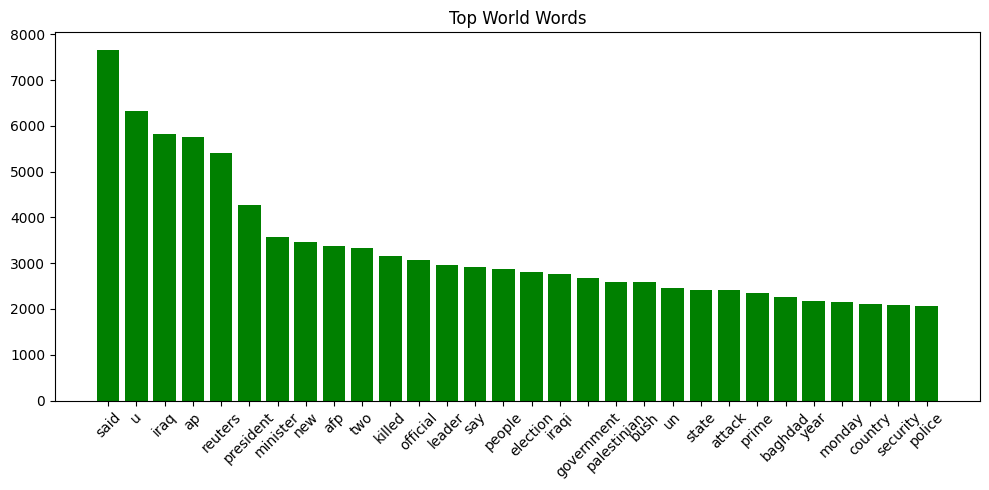

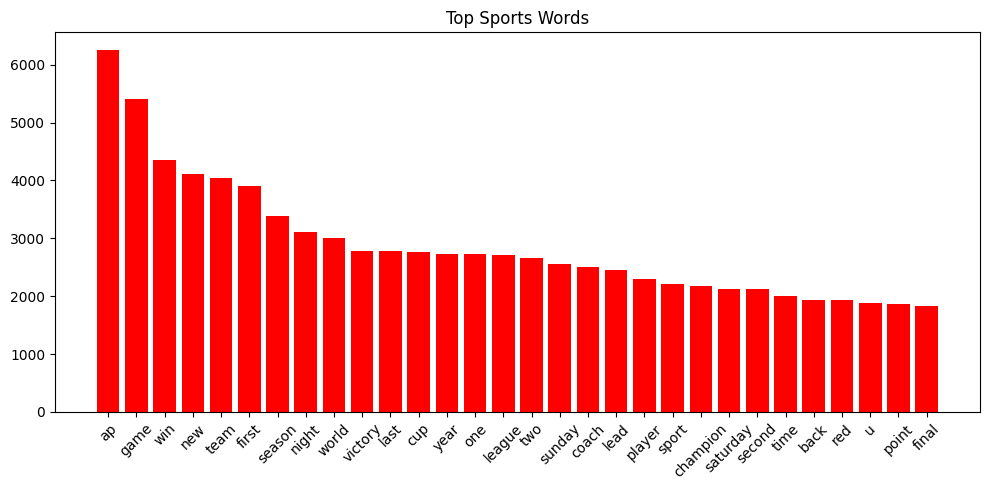

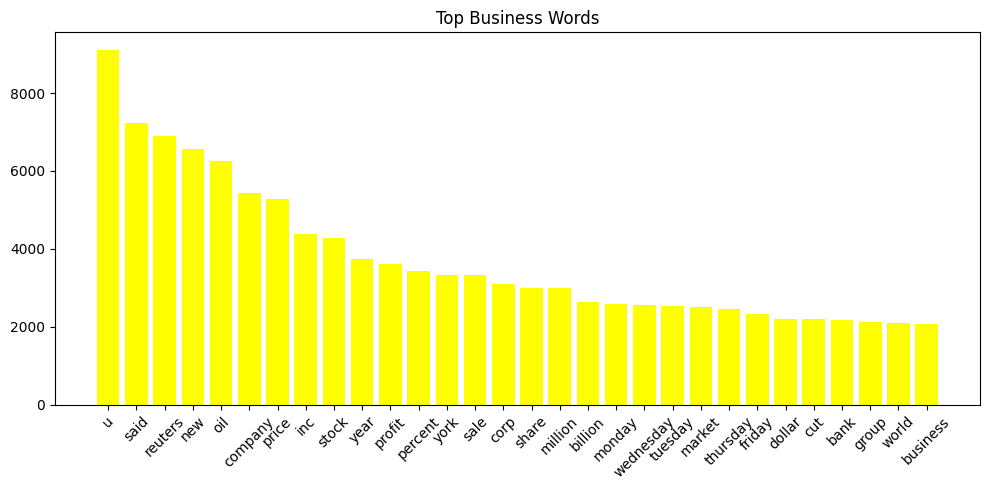

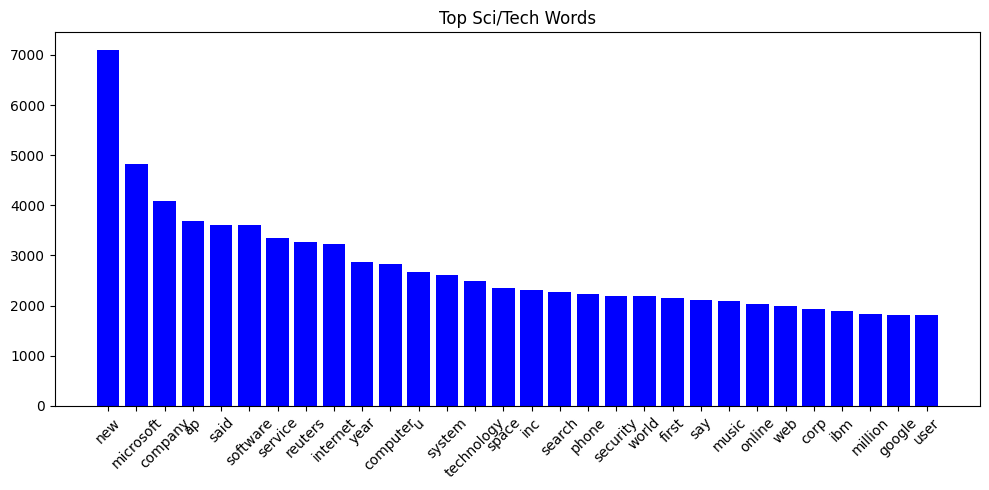

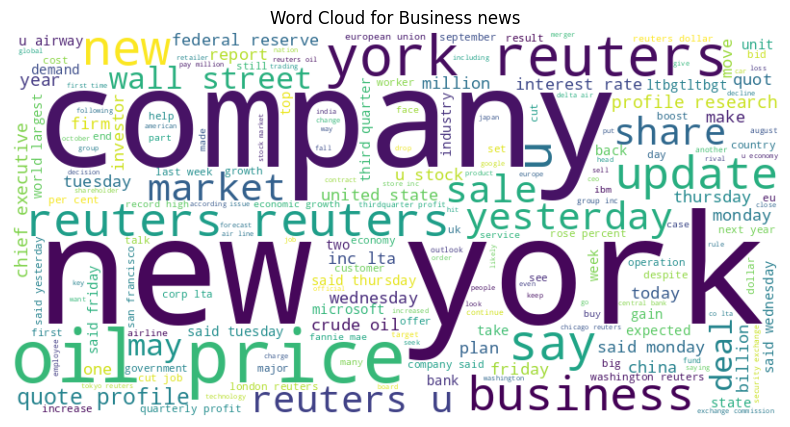

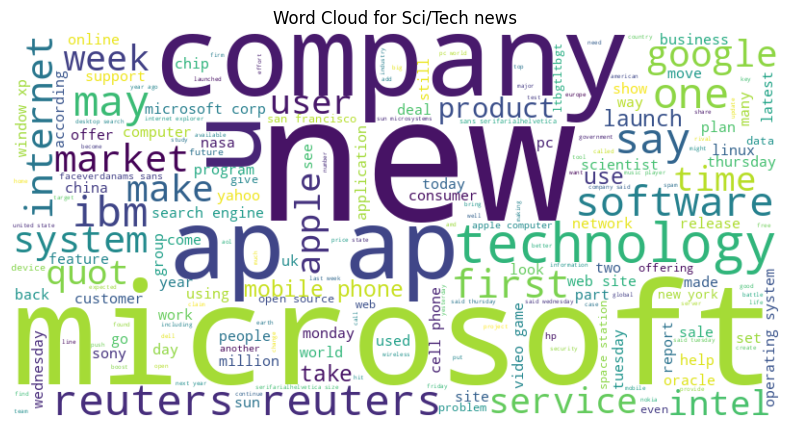

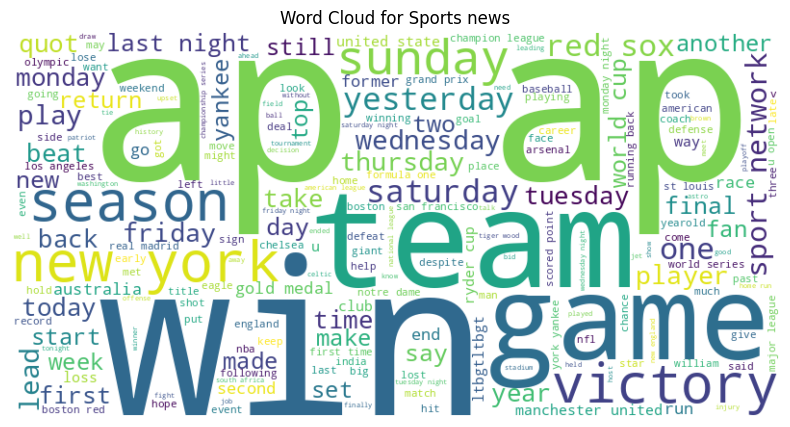

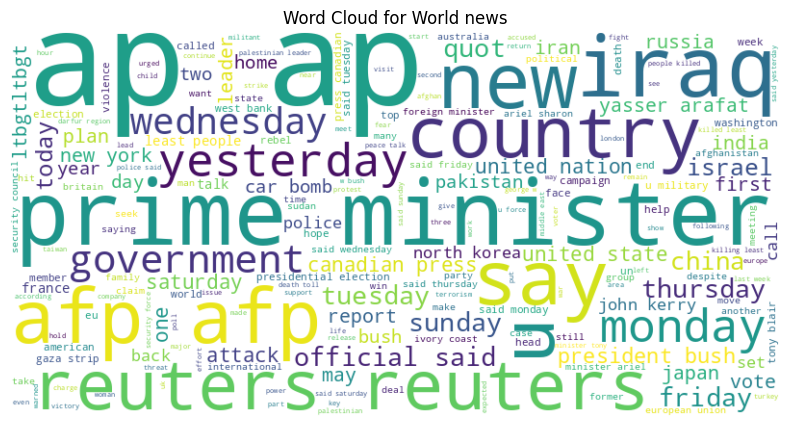

In [12]:
# Bonus
world_text = df[df['Class Index'] == 1]['text']
sports_text = df[df['Class Index'] == 2]['text']
business_text = df[df['Class Index'] == 3]['text']
scitech_text = df[df['Class Index'] == 4]['text']

world_counter = Counter()
sports_counter = Counter()
business_counter = Counter()
scitech_counter = Counter()

for doc in world_text:
    world_counter.update(word_tokenize(doc))

for doc in sports_text:
    sports_counter.update(word_tokenize(doc))

for doc in business_text:
    business_counter.update(word_tokenize(doc))

for doc in scitech_text:
    scitech_counter.update(word_tokenize(doc))

plot_words(world_counter.most_common(30), 'Top World Words', 'green')
plot_words(sports_counter.most_common(30), 'Top Sports Words', 'red')
plot_words(business_counter.most_common(30), 'Top Business Words', 'yellow')
plot_words(scitech_counter.most_common(30), 'Top Sci/Tech Words', 'blue')

for category in df['Class Index'].unique():
    text = ' '.join(df[df['Class Index'] == category]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for { {1:'World', 2:'Sports', 3:'Business', 4:'Sci/Tech'}[category] } news")
    plt.show()



## Feature Extraction

In [75]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)

x_train = tfidf.fit_transform(df['text'])
y_train = (df['Class Index'] - 1).values

In [20]:
print(x_train.shape)
print(y_train.shape)
print(type(x_train))
print(type(y_train))

(120000, 10000)
(120000,)
<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.ndarray'>


## Model Training

In [21]:
logreg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=42)
xgboost = XGBClassifier(n_estimators=300, max_depth=20, random_state=42)

In [22]:
logreg.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [23]:
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=500, random_state=42)

In [24]:
xgboost.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

# Test & Evaluation

In [76]:
# Data testing and evaluation
df_test = pd.read_csv('Dataset/test.csv')
df_test['text'] = df_test['Title'] + " " +  df_test['Description']
df_test['text'] = df_test['text'].apply(preprocess_text)
x_test = tfidf.transform(df_test['text'])
y_test = (df_test['Class Index'] - 1).values

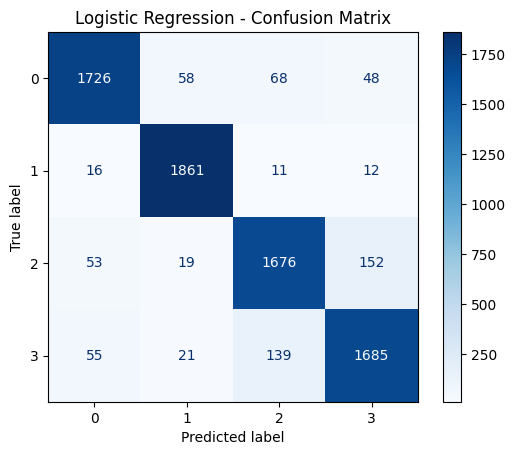

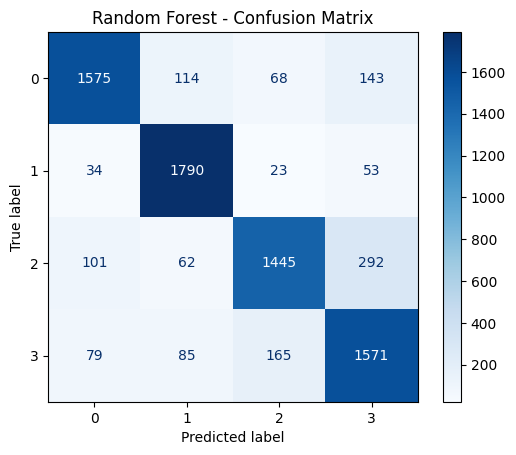

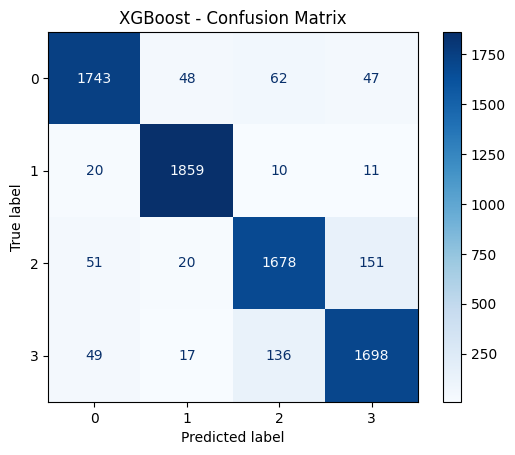

In [26]:
# Maybe we'll add more in the future?
models = {
    'Logistic Regression': logreg,
    'Random Forest': rf,
    'XGBoost': xgboost
}

for name, model in models.items():
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()


In [27]:
for name, model in models.items():
    print(f"Classification report for {name}:\n{classification_report(y_test, model.predict(x_test))}")

Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1900
           1       0.95      0.98      0.96      1900
           2       0.88      0.88      0.88      1900
           3       0.89      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600

Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1900
           1       0.87      0.94      0.91      1900
           2       0.85      0.76      0.80      1900
           3       0.76      0.83      0.79      1900

    accuracy                           0.84      7600
   macro avg       0.84      0.84      0.84      7600
weighted avg       0.84      0.84      0.84      7600

Classification report for XGBoost:
       

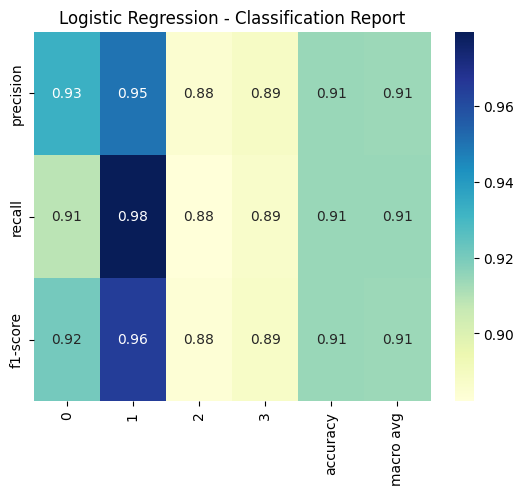

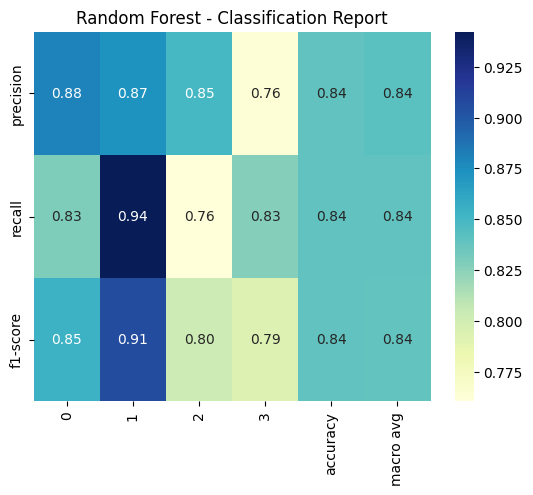

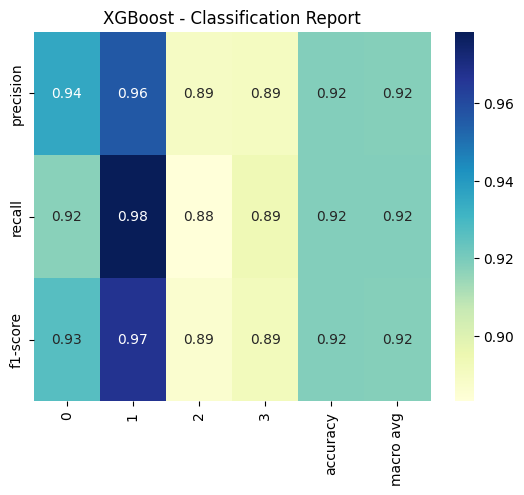

In [28]:
def plot_classification_report_heatmap(y_true, y_pred, title):
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).iloc[:-1, :-1]  # remove support and accuracy
    sns.heatmap(df, annot=True, cmap='YlGnBu', fmt=".2f")
    plt.title(title)
    plt.show()

for name, model in models.items():
    y_pred = model.predict(x_test)
    plot_classification_report_heatmap(y_test, y_pred, f'{name} - Classification Report')


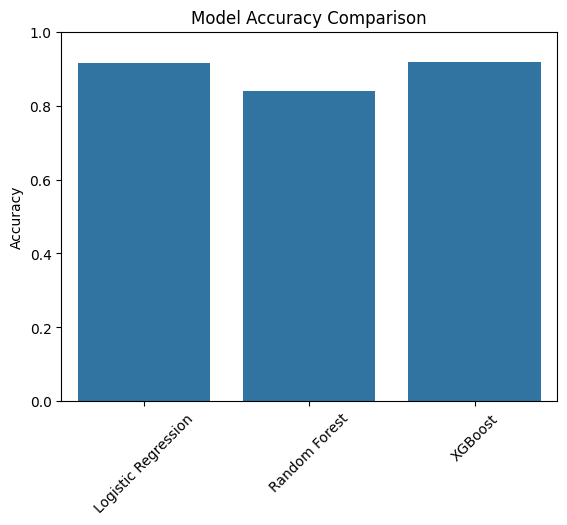

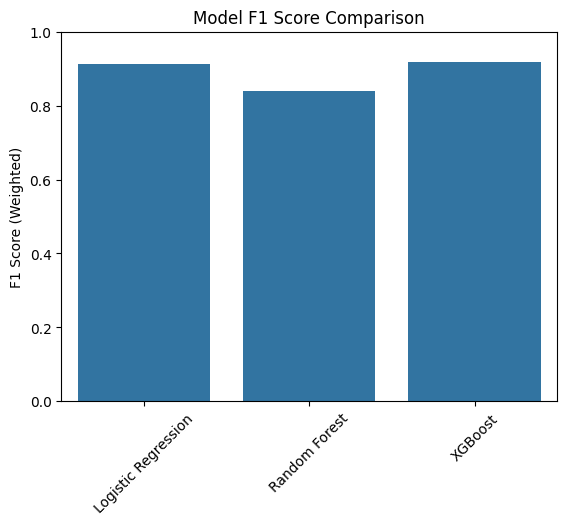

In [29]:
acc_scores = {}
f1_scores = {}

for name, model in models.items():
    y_pred = model.predict(x_test)
    acc_scores[name] = accuracy_score(y_test, y_pred)
    f1_scores[name] = f1_score(y_test, y_pred, average='weighted')

# Accuracy Bar Chart
plt.figure()
sns.barplot(x=list(acc_scores.keys()), y=list(acc_scores.values()))
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

# F1 Score Bar Chart
plt.figure()
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()))
plt.title('Model F1 Score Comparison')
plt.ylabel('F1 Score (Weighted)')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

## Training Neural Network

In [77]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y_train_encoded = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_encoded = enc.transform(y_test.reshape(-1, 1)).toarray()

In [78]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(x_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 642,740 (2.45 MB)

 Trainable params: 642,740 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
history = model.fit(x_train, y_train_encoded, epochs=30, batch_size=60000,
          validation_data=(x_test, y_test_encoded))

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.9091 - loss: 0.4431 - val_accuracy: 0.9017 - val_loss: 0.4403
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.9110 - loss: 0.4118 - val_accuracy: 0.9016 - val_loss: 0.4144
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9123 - loss: 0.3851 - val_accuracy: 0.9026 - val_loss: 0.3925
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9143 - loss: 0.3613 - val_accuracy: 0.9028 - val_loss: 0.3742
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9146 - loss: 0.3429 - val_accuracy: 0.9036 - val_loss: 0.3591
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9162 - loss: 0.3256 - val_accuracy: 0.9047 - val_loss: 0.3467
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9170 - loss: 0.3124 - val_accuracy: 0.9059 - val_loss: 0.3365
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9180 - loss: 0.3007 - val_accuracy: 0.9063 - val_loss: 0.3280
Epoch 9/30
2/2

In [86]:
loss, accuracy = model.evaluate(x_test, y_test_encoded, verbose=1)
print(f"Model Accuracy on the test set: {accuracy:.4f}")

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9080 - loss: 0.2900
Model Accuracy on the test set: 0.9112


In [99]:
rand_ind = np.random.randint(7600)
prediction_probabilities = model.predict(x_test[rand_ind])[0]
# Use np.argmax to get the index of the highest probability, which is the predicted class, and print it

predicted_class = ['World', 'Sports', 'Business', 'Sci/Tech'][np.argmax(prediction_probabilities)]
print(f'Predicted: {predicted_class}\nActual: {["World", "Sports", "Business", "Sci/Tech"][np.argmax(y_test[rand_ind])]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted: World
Actual: World


In [88]:
print(y_pred.shape)
print(y_test.shape)

(7600,)
(7600,)


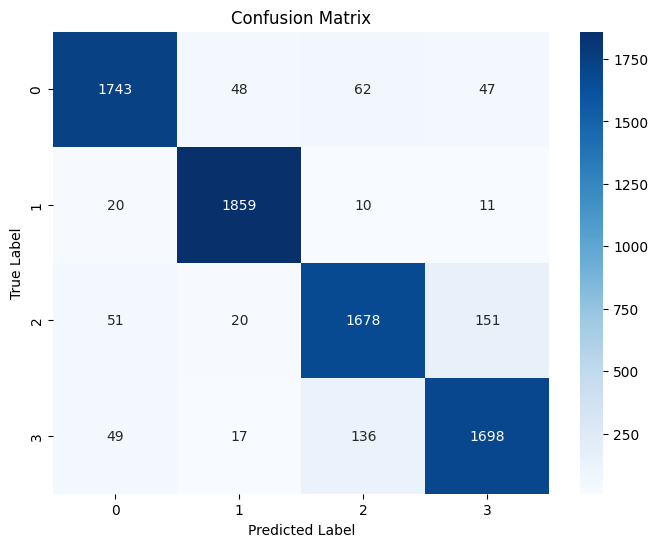

In [89]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

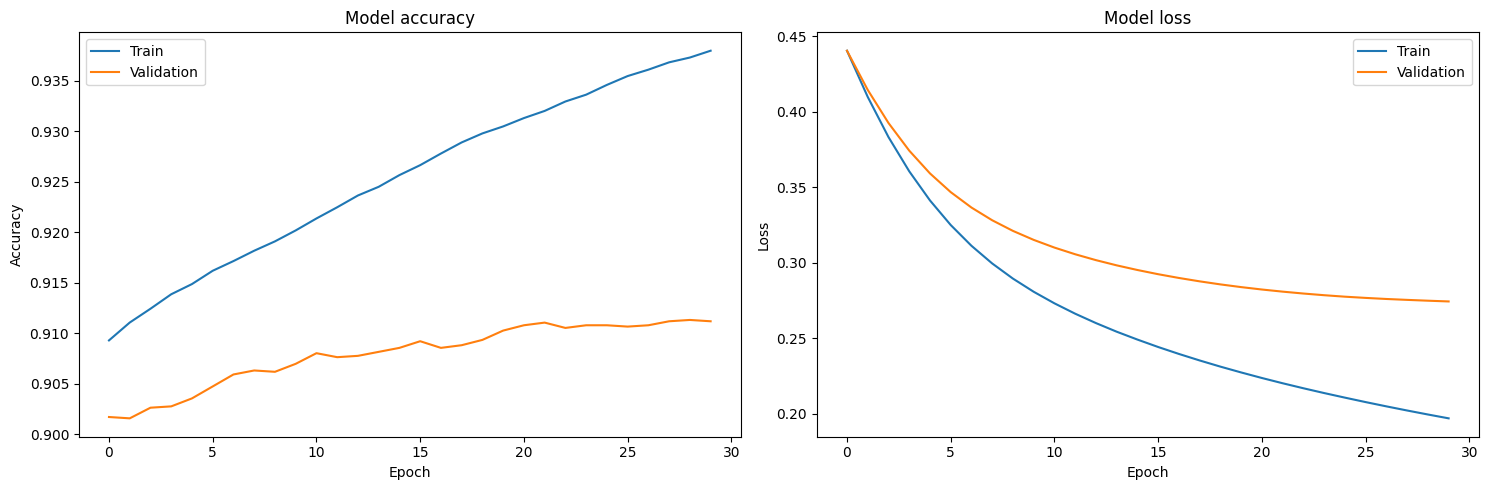

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [98]:
# Save Models
from joblib import dump
dump(logreg, 'LogisticRegression.joblib')
dump(rf, 'RandomForest.joblib')
dump(xgboost, 'XGBoost.joblib')
dump(tfidf, 'TFIDFVectorizer.joblib')
model.save('MLPClassifier_3HL.keras')